# Train a simple Employee promotion prediction model

## Use Case

This notebook demonstrates the implementation of a Random Forest Classification model for predicting employee promotions. The focus is on leveraging training the model with employee historical data for accurate predictions. Employee promotion prediction involves identifying factors that contribute to promotion decisions based on various features. It is an external trained model outside of watson studio and will also be deployed outside watsonx platform. The model will be tracked in watsox.gov with ai factsheet and will be monitored in openscale with explainability, fairness, bias etc

## What you'll learn in this notebook

Random Forest Classification: Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees for robust and accurate predictions. Understand and implement the Random Forest algorithm for predicting employee promotions. The notebook covers the process of extracting relevant features, training the Random Forest model, and evaluating its performance in predicting employee promotions.

In [5]:
# install required libraries
# !pip3 install botocore
# !pip3 install pandas
# !pip3 install matplotlib
# !pip3 install ibm-cos-sdk
# !pip3 install ibm_watson_machine_learning

In [6]:
## Import required libraries
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

## Step 1: Load and prepare the data

In [7]:
## TODO don't forget to remove before putting it in github

API_KEY = '#######'
#PROJECT_ID = os.environ['PROJECT_ID']
LOCATION = 'https://us-south.ml.cloud.ibm.com'

In [14]:
import os, types

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=API_KEY,
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'sapwatsonxintegration-donotdelete-pr-kvn87thfzgndtd'
object_key = 'epp_train.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

employee_data = pd.read_csv(body)
employee_data.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,any_awards_won,is_promoted,kpis_met_above_80_percent,avg_training_score
0,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,0,49
1,66874,Sales & Marketing,region_27,Bachelor's,f,other,1,30,NaN,1,0,0,0,50
2,36904,Sales & Marketing,region_15,Bachelor's,m,other,1,29,3.0,2,0,0,0,51
3,32877,Sales & Marketing,region_2,Bachelor's,f,other,1,40,3.0,12,0,0,0,50
4,58415,Sales & Marketing,region_7,Bachelor's,m,other,1,45,4.0,5,0,0,0,50


In [9]:
employee_data.shape

(54808, 14)

In [15]:
employee_data.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'any_awards_won', 'is_promoted',
       'kpis_met_above_80_percent', 'avg_training_score'],
      dtype='object')

In [16]:
employee_data = employee_data.drop(columns=["employee_id", "recruitment_channel", "region"])
employee_data.columns

Index(['department', 'education', 'gender', 'no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'any_awards_won',
       'is_promoted', 'kpis_met_above_80_percent', 'avg_training_score'],
      dtype='object')

## Step 2: Balance the dataset with respect to is_promoted

Balancing the dataset with respect to the "is_promoted" variable is essential to avoid bias in the predictive model. When the dataset is imbalanced, with one class significantly outnumbering the other (e.g., promoted or not promoted employees), the model may exhibit a tendency to favor the majority class. In the context of employee promotion prediction, imbalance could lead to inaccurate predictions, especially if the majority of instances involve non-promotion.


In [26]:
# Separate the two classes
n = employee_data[employee_data['is_promoted'] == 1].count()[0]
class_0_data = employee_data[employee_data['is_promoted'] == 0]
class_1_data = employee_data[employee_data['is_promoted'] == 1]
print(employee_data['is_promoted'].value_counts())
# Take 3760 samples from class 0
class_0_sampled = class_0_data.sample(n, random_state=42)

# Combine the two classes to create a balanced dataset
employee_data = pd.concat([class_0_sampled, class_1_data])
print(employee_data['is_promoted'].value_counts())

0    4668
1    4668
Name: is_promoted, dtype: int64
0    4668
1    4668
Name: is_promoted, dtype: int64


## Step 3: Data Preprocessing and Train-Test split

Data preprocessing, including handling missing values, encoding categorical columns, and splitting the dataset into training and test sets, with a check on the class distribution in the training data.

In [32]:
employee_data.columns

Index(['department', 'education', 'gender', 'no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'any_awards_won',
       'is_promoted', 'kpis_met_above_80_percent', 'avg_training_score'],
      dtype='object')

In [33]:
# Handle missing values
employee_data["education"].fillna(employee_data["education"].mode()[0], inplace=True)
employee_data["previous_year_rating"].fillna(1, inplace=True)

# Encode categorical columns, The pandas.get_dummies() function is used to convert categorical variables into dummy/indicator variables.
categorical_columns = employee_data.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(employee_data, columns=categorical_columns, drop_first=True)

# Split the data into features (X) and target (y)
y = X_encoded["is_promoted"]
X_encoded = X_encoded.drop("is_promoted", axis=1)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initializing a Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Check the class distribution in the training set
class_counts = y_train.value_counts()
print("Class Distribution in Training Data:")
print(class_counts)

Class Distribution in Training Data:
0    3737
1    3731
Name: is_promoted, dtype: int64


## Step 4: construct metadata for your model.

This will be saved with the model itself and will appear on its Factsheet. 

In [38]:
#!pip3 install --upgrade ibm-aigov-facts-client  --no-cache | tail -n 1
from ibm_aigov_facts_client import AIGovFactsClient

In [36]:
## factsheet metadata variables
EXPERIMENT_NAME='epp_model_employee_promotion_external_01'

In [107]:

### Prepare ai factsheet meta data
# Create a list to store ColumnInfo objects
column_info_list = []

# Iterate over columns and create ColumnInfo objects
for column_name, dtype in zip(X_train.columns, X_train.dtypes):
    cell = {
        "name": column_name,
        "nullable": True, 
        "metadata": {}, 
        "type": str(dtype)
    }
    column_info_list.append(cell)

training_data_references = [
        {
            "id": EXPERIMENT_NAME,
            "type": "s3",
            "connection": {
                "access_key_id": "xNVyWFdMwLvr7zifXOb_IO8EuHCscHPKjqjUQTI8hjia",
                "endpoint_url": "https://s3.direct.us-south.cloud-object-storage.appdomain.cloud",
                "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/e65910fa61ce9072d64902d03f3d4774:2d882273-f864-4224-bde6-d4a74b3143ae::"
            },
            "location": {
                "bucket": "bucket-sap-epp",
                "path": "epp_train.csv"
            },
            "schema": {
                "id": "training_schema",
                "fields": column_info_list
            }
        }
    ]
#training_data_references

inpunt_schema = []

# Iterate over columns and create ColumnInfo objects
for column_name, dtype in zip(X_train.columns, X_train.dtypes):
    cell = {
        "feature": column_name,
        "name": column_name,
        "type": str(dtype)
    }
    inpunt_schema.append(cell)

In [39]:
## AI Govt factsheet client, using external models with manual log option, initiate client as
facts_client= AIGovFactsClient(api_key=API_KEY,experiment_name=EXPERIMENT_NAME,enable_autolog=False,external_model=True)
facts_client.assets.get_ai_usecases()


2024/02/16 09:19:11 INFO : Experiment successfully created with ID 1 and name epp_model_employee_promotion_external_01
2024/02/16 09:19:12 INFO : AI usecases retrieved successfully


[{
   "model_usecase_id": "626b4d8f-da1c-4399-bcb5-b4e11c0cb8c4",
   "container_type": "catalog",
   "catalog_id": "581bc939-f7e4-4484-bf64-97351f6d01ce"
 },
 {
   "model_usecase_id": "ee77712c-6190-4cf9-b331-36b30e2eee07",
   "container_type": "catalog",
   "catalog_id": "518fb947-be3f-43a9-90e1-7db41fc8ac09"
 }]

In [109]:
from ibm_aigov_facts_client.supporting_classes.factsheet_utils import DeploymentDetails,TrainingDataReference,ExternalModelSchemas, ModelDetails

## Specify model details
model_details = ModelDetails(
    model_type = "scikit-learn_1.1"
    ,input_type = "object"
    ,algorithm = "RandomForestClassifier"
    ,label_type = "class_counts"
    ,label_column = "is_promoted"
    ,prediction_type = "Binary Classification"
    ,software_spec = "runtime-23.1-py3.10"
    ,provider = "Custom Environment"
    )

## Specify training reference data
trainingdataref=TrainingDataReference(id=EXPERIMENT_NAME,
            type = "url",
            connection = {
                "url": "https://cloud.ibm.com/objectstorage/crn%3Av1%3Abluemix%3Apublic%3Acloud-object-storage%3Aglobal%3Aa%2Fe65910fa61ce9072d64902d03f3d4774%3A2d882273-f864-4224-bde6-d4a74b3143ae%3A%3A?bucket=bucket-sap-epp&bucketRegion=us-south&endpoint=s3.us-south.cloud-object-storage.appdomain.cloud&paneId=bucket_overview",
            },
            location = {
                "bucket": "bucket-sap-epp",
                "path": "epp_train.csv",
                "source": "epp_train.csv"
            },
            schema = {
                "id": "training_schema",
                "fields": column_info_list
            })

## Model deployment details
deployment=DeploymentDetails(identifier='http://169.46.68.130:8080/',name=EXPERIMENT_NAME,deployment_type="online",scoring_endpoint="/v2/predict_and_log")

## input and output schema definition
external_schemas=ExternalModelSchemas(input=[{"fields": inpunt_schema,
   }], output=[{"fields": [
        {'feature': 'is_promoted', 'name': 'is_promoted', 'type': 'uint8'}
    ]}])

In [121]:
## Save external model facts to watsonx.gov

watsonx_factsheet = facts_client.external_model_facts.save_external_model_asset(model_identifier="sap-hr-use-case"
                                                            ,name=EXPERIMENT_NAME
                                                            ,description="SAP AI Core integration, HR promotion usecase"
                                                            ,deployment_details=deployment
                                                            ,training_data_reference=trainingdataref
                                                            ,model_details=model_details
                                                            ,schemas=external_schemas
                                                            )


2024/02/16 11:55:25 INFO : External model asset saved successfully under asset_id 0d5a4d6d-f87a-4248-a910-792bf285e011 and catalog 518fb947-be3f-43a9-90e1-7db41fc8ac09
2024/02/16 11:55:26 INFO : Current model information: {'asset_id': '0d5a4d6d-f87a-4248-a910-792bf285e011', 'container_type': 'catalog', 'container_id': '518fb947-be3f-43a9-90e1-7db41fc8ac09', 'facts_type': 'modelfacts_user'}


In [128]:
#watsonx_factsheet.add_tracking_model_usecase(model_usecase_name="Platform Asset Catalog"

## Step 5: Train the Random forest classfier model

Initialization, training, and testing of a Random Forest Classifier with balanced class weights for predicting promotions in an employee dataset

In [137]:
# Initialize a Random Forest Classifier with balanced class weights
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=100)

# Training the model
rf_classifier.fit(X_train, y_train)

# Testing data prediction
y_pred = rf_classifier.predict(X_test)

# Traing data prediction
yt_pred = rf_classifier.predict(X_train)

In [130]:
# List of feature columns 
X_encoded.columns

Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'any_awards_won', 'kpis_met_above_80_percent', 'avg_training_score',
       'department_Finance', 'department_HR', 'department_Legal',
       'department_Operations', 'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'education_Below Secondary', 'education_Master's & above', 'gender_m'],
      dtype='object')

## Step 6: Model Evaluation

Evaluating the training and testing accuracy scores of a Random Forest Classifier for employee promotion prediction.

In [131]:
# Calculating accuracy
train_accuracy = accuracy_score(y_train, yt_pred)

print("train_accuracy",train_accuracy)

test_accuracy = accuracy_score(y_test, y_pred)

print("test_accuracy",test_accuracy)

train_accuracy 0.9961167648634173
test_accuracy 0.7853319057815846


In [138]:
#testing data 
pred_df={'no_of_trainings': {0: 1,
  1: 1,
  2: 1,
  3: 2,
  4: 1,
  5: 2,
  6: 1,
  7: 1,
  8: 1,
  9: 1},
 'age': {0: 35, 1: 30, 2: 34, 3: 39, 4: 45, 5: 31, 6: 31, 7: 33, 8: 28, 9: 32},
 'previous_year_rating': {0: 5.0,
  1: 5.0,
  2: 3.0,
  3: 1.0,
  4: 3.0,
  5: 3.0,
  6: 3.0,
  7: 3.0,
  8: 4.0,
  9: 5.0},
 'length_of_service': {0: 8,
  1: 4,
  2: 7,
  3: 10,
  4: 2,
  5: 7,
  6: 5,
  7: 6,
  8: 5,
  9: 5},
 'any_awards_won': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 'kpis_met_above_80_percent': {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1},
 'avg_training_score': {0: 49,
  1: 60,
  2: 50,
  3: 50,
  4: 73,
  5: 85,
  6: 59,
  7: 63,
  8: 83,
  9: 54},
 'department_Finance': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_HR': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 'department_Legal': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_Operations': {0: 0,
  1: 1,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 1,
  7: 1,
  8: 0,
  9: 0},
 'department_Procurement': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_R&D': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'department_Sales & Marketing': {0: 1,
  1: 0,
  2: 1,
  3: 1,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 1},
 'department_Technology': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 1,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 'education_Below Secondary': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 "education_Master's & above": {0: 1,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 1,
  8: 0,
  9: 1},
 'gender_m': {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1}}
pred_df=pd.DataFrame(pred_df)

In [139]:
y_prob = rf_classifier.predict_proba(pred_df)
y_prob

array([[0.38  , 0.62  ],
       [0.85  , 0.15  ],
       [1.    , 0.    ],
       [1.    , 0.    ],
       [0.88  , 0.12  ],
       [0.7625, 0.2375],
       [0.99  , 0.01  ],
       [0.95  , 0.05  ],
       [0.86  , 0.14  ],
       [0.65  , 0.35  ]])

In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Compute precision
precision = precision_score(y_test, y_pred)
print(precision)

# Compute recall
recall = recall_score(y_test, y_pred)
print(recall)

# Compute F1-score
f1 = f1_score(y_test, y_pred)
print(f1)

0.7557251908396947
0.8452508004268944
0.797984886649874


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       931
           1       0.76      0.85      0.80       937

    accuracy                           0.79      1868
   macro avg       0.79      0.79      0.78      1868
weighted avg       0.79      0.79      0.78      1868

F1 Score: 0.80
Recall: 0.85
Precision: 0.76
AUC Score: 0.87


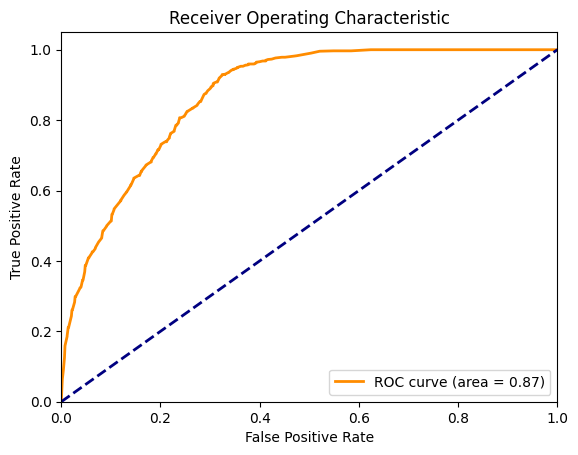

In [141]:
# Get predicted probabilities for class 1
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# custom_threshold = 0.4  # You can adjust this value
# y_pred = (y_prob >= custom_threshold).astype(int)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Step 7: Save the model as pickle

Saving a trained Random Forest Classifier model to a file using joblib and subsequently loading it for future use.

In [144]:
import joblib

# Save the model to a file
joblib.dump(rf_classifier, 'epp_model_rf_nw.pkl')

# Load the model from the file
# loaded_model = joblib.load('epp_model_rf_nw.pkl')

# Upload the model 
# wslib.upload_file(file_path="epp_model_rf_nw.pkl", asset_name="epp_model_rf_nw.pkl", overwrite=True)

['epp_model_rf_nw.pkl']

In [145]:
help(ModelDetails)

Help on class ModelDetails in module ibm_aigov_facts_client.supporting_classes.factsheet_utils:

class ModelDetails(builtins.object)
 |  ModelDetails(model_type: str = None, input_type: str = None, algorithm: str = None, label_type: str = None, label_column: str = None, prediction_type: str = None, software_spec: str = None, software_spec_id: str = None, provider: str = None) -> None
 |  
 |  External model model details
 |  
 |  :attr str model_type: Value for model type
 |  :attr str input_type: Value for inout type
 |  :attr str algorithm: Value for algorithm
 |  :attr str label_type: Value for label type
 |  :attr str label_column: Value for label column
 |  :attr str prediction_type: Value for prediction type
 |  :attr str software_spec: Value for software_spec
 |  :attr str software_spec_id: Value for software_spec_id
 |  :sttr str provider: Value for provider
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other: 'ModelDetails') -> bool
 |      Return `true` when self and o